<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Clustering Logistics Research Papers
[Part 1: Get Abstract](01_Get_Abstrast.ipynb) | [Part 2: Add Label](02_Add_Label.ipynb) |  [Part 3: EDA](03_EDA.ipynb) | **Part 4: Keywords** |**Part 5: Neural Network model**


In [217]:
import pandas as pd
import matplotlib
import seaborn as sns

from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_words, thai_stopwords
from pythainlp.util import dict_trie

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from imblearn.over_sampling import SMOTE, ADASYN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [218]:
df = pd.read_csv('../data/cleaned_abstract.csv')
df.head()

,project,abstract,category,keywords,category_id,abstract_length,abstract_word_count
0,การจัดทำคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟ...,ผู้วิจัยได้ตระหนักถึงความยุ่งยากของขั้นตอนการน...,การนำเข้า-ส่งออกและการค้าระหว่างประเทศ,"คู่มือการนำเข้าคราฟท์เบียร์, การดำเนินงานตามมา...",6,859,170
1,การเสนอแนวทางในการพัฒนาและสร้างความสัมพันธ์กับ...,งานวิจัยครั้งนี้มีวัตถุประสงค์เพื่อเสนอแนวทางใ...,การจัดซื้อจัดหา,"การประเมินการปฏิบัติงาน, ผู้ส่งมอบ, แบ่งเกรด, ...",1,1172,258
2,การพัฒนามาตรฐานรถขนส่งวัตถุอันตรายที่เข้ามาในค...,ดำเนินธุรกิจเป็นผู้นำเข้า และจัดจำหน่ายสินค้าก...,การนำเข้า-ส่งออกและการค้าระหว่างประเทศ,"Chemical Solvent, การควบคุมความปลอดภัย, รถขนส่...",6,1964,383
3,แนวทางการปรับปรุงกระบวนการการส่งเอกสารใบกำกับภ...,การวิจัยครั้งนี้มีวัตถุประสงค์ เพื่อศึกษาขั้นต...,การจัดซื้อจัดหา,"การวิจัย, กระบวนการจัดส่งใบกำกับภาษี, แผนกบัญช...",1,1252,264
4,การศึกษาเทคนิคการพยากรณ์ยอดขายสายไฟที่เหมาะสม,จากสถานการณ์การแพร่ระบาดของเชื้อไวรัสโคโรนา 20...,การวางแผนและพยากรณ์ความต้องการ,"Keywords: โควิด-19, ยานยนต์, การพยากรณ์ยอดขาย,...",5,1924,478


In [219]:
# Add custom word to keep from 5 sample abstract
added_words = ['การนำเข้า', 'ฐานนิยม', 'คราฟท์', 'แนวทาง', 'ผู้ส่งมอบ', 'โซ่อุปทาน', 'ปัจจัยรอง', 
               'การส่งมอบ', 'รถขนส่ง', 'นำไปใช้งาน', 'อย่างถูกต้อง', 'การขับรถ', 'ที่เกี่ยวข้อง', 
               'ในการปฏิบัติงาน', 'พนักงานขับรถ', 'สิ่งสำคัญ', 'ขั้นตอน', 'ที่ชัดเจน', 'การไหล', 'ยอดขาย', 
              'การจัดทำ', 'คราฟท์เบียร์', 'ฝึกสหกิจ', 'อย่างก้าวกระโดด','การจัดซื้อจัดหา','กระบวนการ',
               'แบบประเมิน','เก็บข้อมูล','อย่างชัดเจน','การดำเนินการ','การส่งเสริม','ถังดับเพลิง','แนวทาง']

# Merge custom words with Thai dictionary words
custom_words = set(thai_words()).union(added_words)
custom_trie = dict_trie(custom_words)  # Create a trie from the custom dictionary

In [220]:
def preprocess_text(text):
    stopwords = thai_stopwords()
    tokens = word_tokenize(text, custom_dict= custom_trie, engine="newmm")
    return " ".join([word for word in tokens if word not in stopwords])

In [221]:
# abstract tokenization
df['abstract_tokens'] = df['abstract'].apply(preprocess_text)

In [222]:
df['category'].value_counts()

category
การจัดการสินค้าคงคลัง                     138
โลจิสติกส์และการกระจายสินค้า               52
การนำเข้า-ส่งออกและการค้าระหว่างประเทศ     48
การจัดซื้อจัดหา                            47
การผลิต                                    32
การวางแผนและพยากรณ์ความต้องการ             20
อื่นๆ                                       2
ความยั่งยืนและจริยธรรมในซัพพลายเชน          1
Name: count, dtype: int64

In [223]:
# Remove the category 'ความยั่งยืนและจริยธรรมในซัพพลายเชน' because it has only one entry in the dataset."
df = df[~df['category'].isin(['ความยั่งยืนและจริยธรรมในซัพพลายเชน','อื่นๆ'])]

In [224]:
X = df['abstract_tokens']
y = df['category']

In [225]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify = y)

In [226]:
# Use TF-IDF to be transfomer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [227]:
shape = X_train_tfidf.shape[1]

In [228]:
# model Neural Network
nn_model = Sequential()
nn_model.add(Input(shape=(shape,)))
nn_model.add(Dense(512, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(len(df['category_id'].unique()), activation='softmax'))  # Softmax สำหรับ multi-class classification

# model compile
nn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# transform y_train and y_test to numeric
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# train model
nn_model.fit(X_train_tfidf, y_train_encoded, epochs=15, batch_size=16, validation_data=(X_test_tfidf, y_test_encoded) ,verbose = 0);

In [229]:
# predict
y_pred_nn = nn_model.predict(X_test_tfidf, verbose= 0)
y_pred_nn = y_pred_nn.argmax(axis=1)  # transform predict value to class

# transform y back to value
y_pred_nn = label_encoder.inverse_transform(y_pred_nn)

print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))

Neural Network Accuracy: 0.6372549019607843


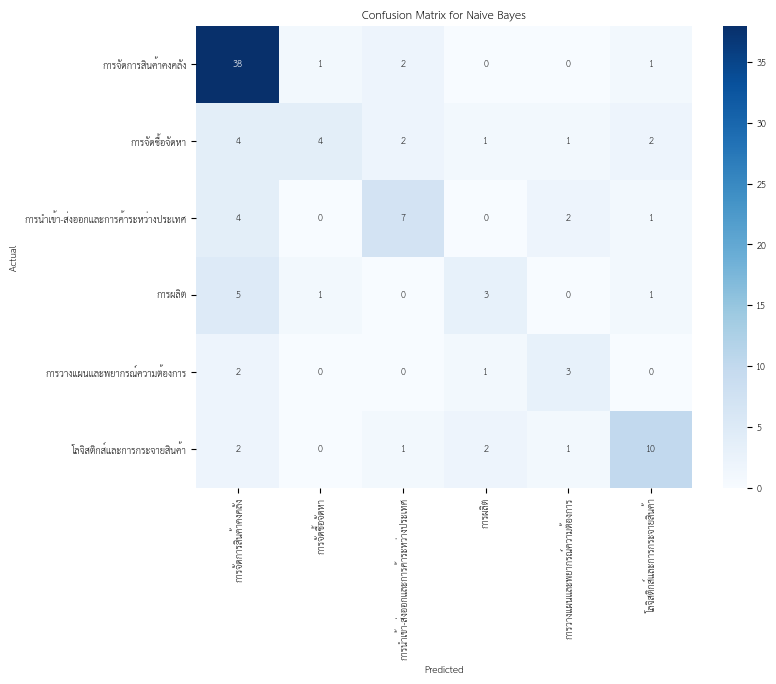

In [230]:
# Set a font that supports Thai characters.
matplotlib.rcParams['font.family'] = 'TH SarabunPSK'

# create confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)

# create heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

In [237]:
# Handle imbalance classes

In [231]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train_encoded)

# Train the model with the resampled data
nn_model.fit(X_train_resampled, y_train_resampled, epochs=15, batch_size=16, validation_data=(X_test_tfidf, y_test_encoded),verbose = 0);

In [232]:
# predict
y_pred_nn = nn_model.predict(X_test_tfidf, verbose= 0)
y_pred_nn = y_pred_nn.argmax(axis=1)  # transform predict value to class

# transform y back to value
y_pred_nn = label_encoder.inverse_transform(y_pred_nn)

print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))

Neural Network Accuracy: 0.6764705882352942


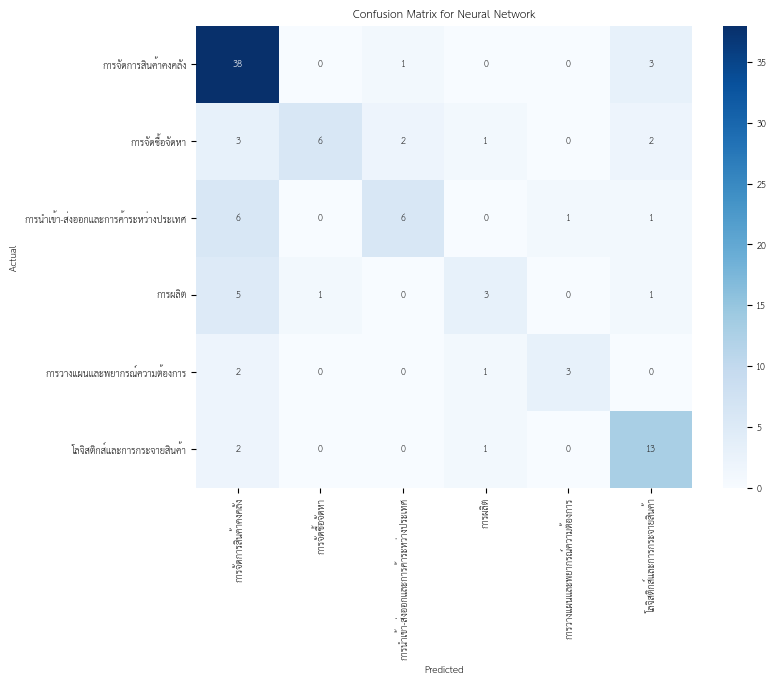

In [233]:
# Set a font that supports Thai characters.
matplotlib.rcParams['font.family'] = 'TH SarabunPSK'

# create confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)

# create heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Neural Network')
plt.show()

In [234]:
# Apply ADASYN to balance the classes
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_tfidf, y_train_encoded)

# Train the model with the resampled data
nn_model.fit(X_train_resampled, y_train_resampled, epochs=15, batch_size=16, validation_data=(X_test_tfidf, y_test_encoded),verbose = 0);

In [235]:
# predict
y_pred_nn = nn_model.predict(X_test_tfidf, verbose= 0)
y_pred_nn = y_pred_nn.argmax(axis=1)  # transform predict value to class

# transform y back to value
y_pred_nn = label_encoder.inverse_transform(y_pred_nn)

print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))

Neural Network Accuracy: 0.6078431372549019


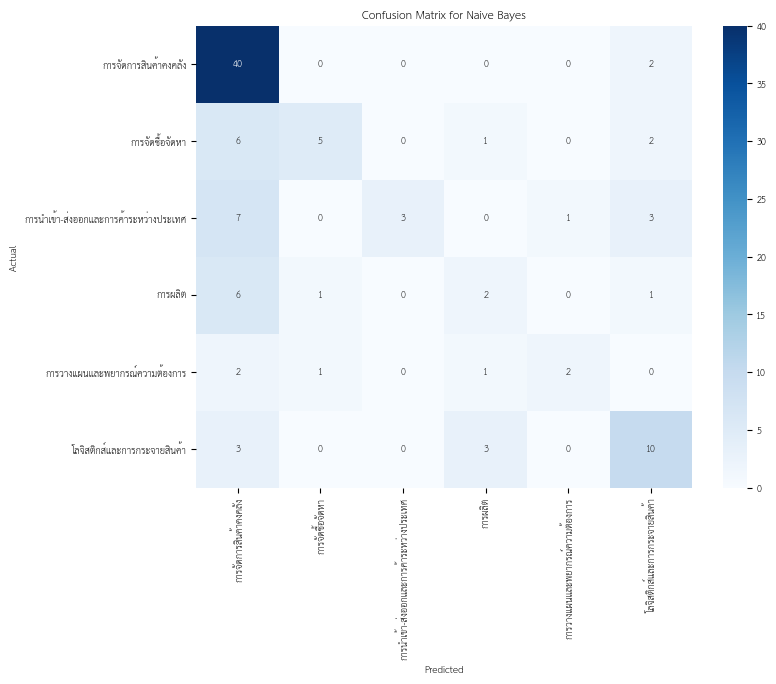

In [236]:
# Set a font that supports Thai characters.
matplotlib.rcParams['font.family'] = 'TH SarabunPSK'

# create confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)

# create heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()